# **Project Background**

In e-commerce opeartional, data is a powerful asset to have that can be used to understand customer behavior, improve sales strategies, and enhance overall business performance. The dataset used is a dummy dataset generated to simulate various aspects of e-commerce platform. This case study is going to be analyzed using Google's 6 Steps of the Data Analysis Process:
1. Ask
2. Prepare
3. Process
4. Analyze
5. Share
6. Act

## **1. Ask**

What we will do in this analysis:

1. Identify different customer segments based on their demographic and behavioral characteristics.
2. Develop targeted marketing strategies for different customer segments.

## **2. Prepare**

The data is provided through [Kaggle](https://www.kaggle.com/datasets/muhammadroshaanriaz/e-commerce-trends-a-guide-to-leveraging-dataset) and contains 11 columns. Detailed information about each column is provided below:

1. `ProductID` (numeric)
2. `ProductName` (object)
3. `Category` (object)
4. `Price` (numeric)
5. `Rating` (numeric)
6. `NumReviews` (numeric)
7. `StockQuantity` (numeric)
8. `Discount` (numeric)
9. `Sales` (numeric)
10. `DateAdded` (object)
11. `City` (object)

## **3. Process**
To answer all the questions, firstly, we need to clean the data.

In [148]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Silence the warnings
import warnings
warnings.filterwarnings('ignore')

Now, import the dataset.

In [149]:
df = pd.read_csv('ecommerce_product_dataset.csv')

df.head()

,ProductID,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,City
0,1,Headphones,Electronics,400.31,1.7,3772,20,0.08,466,2023-11-10,Albuquerque
1,2,Headphones,Electronics,235.03,2.3,2919,663,0.33,1332,2023-09-28,Queens
2,3,Smartwatch,Electronics,417.90,1.8,1184,459,0.31,252,2023-10-20,Austin
3,4,Smartphone,Electronics,152.70,3.4,2047,475,0.49,1806,2023-12-05,Dallas
4,5,Laptop,Electronics,394.74,1.8,1267,831,0.23,1508,2023-08-10,Tucson


Check the data types for all columns.

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ProductID      1000 non-null   int64  
 1   ProductName    1000 non-null   object 
 2   Category       1000 non-null   object 
 3   Price          1000 non-null   float64
 4   Rating         1000 non-null   float64
 5   NumReviews     1000 non-null   int64  
 6   StockQuantity  1000 non-null   int64  
 7   Discount       1000 non-null   float64
 8   Sales          1000 non-null   int64  
 9   DateAdded      1000 non-null   object 
 10  City           1000 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 86.1+ KB


Several changes can be made into the data types to ease out the EDA:

- Change the `DateAdded` into datetime64.
- Change the `DateAdded`, `ProductID`, `ProductName`, `Category`, and `City` into category since it usually more-memory efficient than the object data type.


Also, there is no identified null missing values in the dataset. However, it should still be checked for duplicates.

In [151]:
# Function to convert data as datetime64[ns]
def convert_dates(date_series):
    formats = ['%d/%m/%Y', '%d-%m-%Y', '%m/%d/%Y', '%Y-%m-%d']

    for fmt in formats:
        try:
            return pd.to_datetime(date_series, format=fmt)
        except ValueError:
            continue
    raise ValueError("Date format not recognized")

# Convert and extract from DateAdded
df['DateAdded'] = df['DateAdded'].apply(lambda x: convert_dates(x))
df['Day'] = df['DateAdded'].dt.day_name().astype('category')
df['Month'] = df['DateAdded'].dt.month_name().astype('category')

# Convert object variable to category to preserve memory usage
df['ProductID'] = df['ProductID'].astype('category')
df['ProductName'] = df['ProductName'].astype('category')
df['Category'] = df['Category'].astype('category')
df['City'] = df['City'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ProductID      1000 non-null   category      
 1   ProductName    1000 non-null   category      
 2   Category       1000 non-null   category      
 3   Price          1000 non-null   float64       
 4   Rating         1000 non-null   float64       
 5   NumReviews     1000 non-null   int64         
 6   StockQuantity  1000 non-null   int64         
 7   Discount       1000 non-null   float64       
 8   Sales          1000 non-null   int64         
 9   DateAdded      1000 non-null   datetime64[ns]
 10  City           1000 non-null   category      
 11  Day            1000 non-null   category      
 12  Month          1000 non-null   category      
dtypes: category(6), datetime64[ns](1), float64(3), int64(3)
memory usage: 112.9 KB


In [152]:
df.duplicated().sum()

0

Now, we should rearrange the days or months extracted in order.

In [153]:
day_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day'] = pd.Categorical(df['Day'], categories=day_ordered, ordered=True)

month_ordered = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_ordered, ordered=True)

As there are no duplicates in the dataset, we can proceed. However, before we proceed, we should make a new column/feature for Total Revenue of each product.

In [154]:
df['Revenue'] = (df['Sales'] * (df['Price'] - (df['Price'] * df['Discount'])))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ProductID      1000 non-null   category      
 1   ProductName    1000 non-null   category      
 2   Category       1000 non-null   category      
 3   Price          1000 non-null   float64       
 4   Rating         1000 non-null   float64       
 5   NumReviews     1000 non-null   int64         
 6   StockQuantity  1000 non-null   int64         
 7   Discount       1000 non-null   float64       
 8   Sales          1000 non-null   int64         
 9   DateAdded      1000 non-null   datetime64[ns]
 10  City           1000 non-null   category      
 11  Day            1000 non-null   category      
 12  Month          1000 non-null   category      
 13  Revenue        1000 non-null   float64       
dtypes: category(6), datetime64[ns](1), float64(4), int64(3)
memory usage: 120

## **3.1 EDA: Univariate Analysis**

##### **Summary Statistics**

In [155]:
df.describe().round(2)

,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,Revenue
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000,1000.00
mean,253.78,3.03,2498.75,495.40,0.25,1011.04,2023-12-10 16:06:14.400000,194232.58
min,10.11,1.00,3.00,0.00,0.00,0.00,2023-06-14 00:00:00,0.00
25%,133.09,2.10,1201.75,241.75,0.13,502.00,2023-09-09 00:00:00,53611.78
50%,251.31,3.10,2476.00,505.00,0.25,998.00,2023-12-05 12:00:00,142952.44
75%,375.83,4.00,3797.50,743.50,0.38,1540.00,2024-03-09 00:00:00,295546.90
max,499.74,5.00,4994.00,993.00,0.50,1997.00,2024-06-11 00:00:00,758002.49
std,141.40,1.15,1463.24,292.80,0.15,582.11,NaN,172834.76


Observation results:
- **Date Range**: The dataset spans from 14th June 2023 to 11th June 2024.
- **Potential Outliers**: The dataset does not show any sign of outliers. This might be due to the fact that this dataset is generated for educational purposes and is away from error and real-world cases.
- **Distribution**: By observation from this summary statistics, it can be said that this data set has a normal distribution.

Next, we should see the dataset summary statistics of categorical/string columns.

In [156]:
df.describe(include=['object', 'category'])

,ProductID,ProductName,Category,City,Day,Month
count,1000,1000,1000,1000,1000,1000
unique,1000,100,25,101,7,12
top,1,Biography,Art and crafting materials,New York,Thursday,July
freq,1,22,40,17,155,100


Observation results:
- **Products**: There are 100 unique variables and the top product is **Biography**, accounting for 22 transactions.
- **Category**: There are 25 product category and the top category is **Art and crafting materials**, accounting for 40 transactions.
- **City**: There are 101 uniqu cities with transactions and **New York**  has the highest amount of transactions compared to the other cities, accounting for a total of 17 transaction frequncy.

## **3.2 EDA: Distributions**
First, let's see the distribution of all numeric variables using box plots.

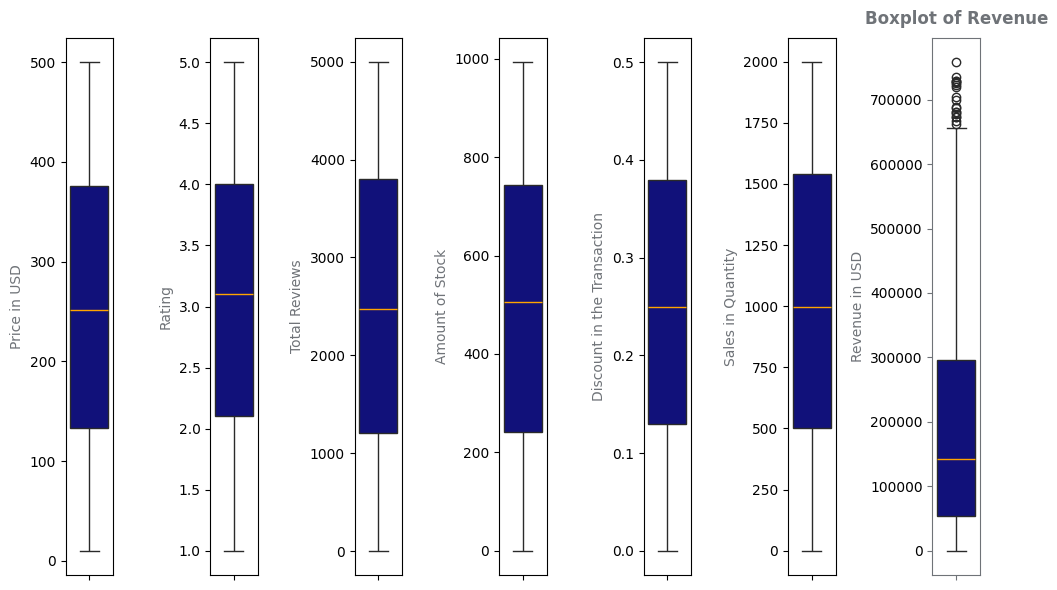

In [157]:
# Get numeric variable
num_var = df.select_dtypes(exclude=['object', 'datetime64[ns]', 'category']).columns.tolist()

# Set the figure and axes
fig, ax = plt.subplots(1, 7, figsize=(10, 6))

# Box plots of numeric columns
for i in range(len(num_var)):

    # Create the box plot
    sns.boxplot(data=df, y=num_var[i], color='darkblue',
                medianprops=dict(color='orange'), ax=ax[i])
    
    if num_var[i] == 'Price':
        ax[i].set_ylabel('Price in USD', color='#6F7378')
    elif num_var[i] == 'Rating':
        ax[i].set_ylabel('Rating', color='#6F7378')
    elif num_var[i] == 'NumReviews':
        ax[i].set_ylabel('Total Reviews', color='#6F7378')
    elif num_var[i] == 'StockQuantity':
        ax[i].set_ylabel('Amount of Stock', color='#6F7378')
    elif num_var[i] == 'Discount':
        ax[i].set_ylabel('Discount in the Transaction', color='#6F7378')
    elif num_var[i] == 'Sales':
        ax[i].set_ylabel('Sales in Quantity', color='#6F7378')
    else:
        ax[i].set_ylabel('Revenue in USD', color='#6F7378')

# Change the tick color
ax[i].tick_params(color='#6F7378')


for spine in ax[i].spines.values():
    spine.set_edgecolor('#6F7378')

ax[i].set_title(f'Boxplot of {num_var[i]}', weight='bold', color='#6F7378', pad=10)

plt.tight_layout()
plt.show()

It can be seen that all of the numeric variable is normally distributed and we can infer the following:
- The common `Price` range falls between approximately $150 and $390.
- The common `Rating` range falls between approximately 2.1 and 4.0 with in the scale of 1 to 5.
- The common `NumReviews` range falls between approximately 1,150 to 3,900 reviews.
- The common `StockQuantity` range fall between approximately 220 to 780.
- The common `Discount` range falls between approximately 0.14 to 0.38.
- The common `Sales` in quantity, range falls between approximately 500 to 1600.
- `Revenue` has global outliers which makes determining the central tendency of price and quantity would be difficult.

Therefore, we need to visualize the distribution of the majority of the data by adjusting the y-axis limit to only focus o the box part.

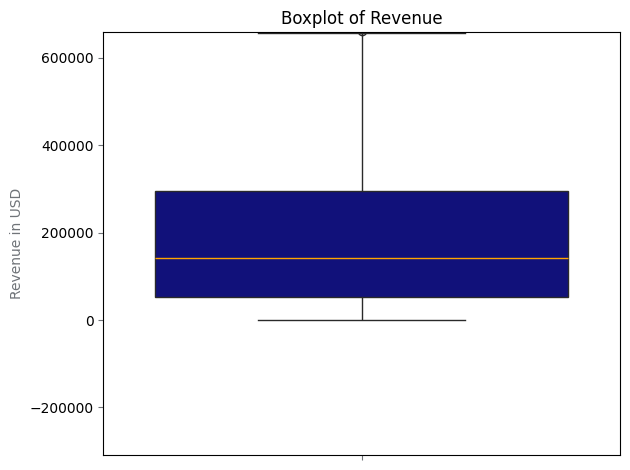

In [158]:
# Set the figure and area
fig, ax = plt.subplots()

# Plot the boxplot
sns.boxplot(data=df, y='Revenue', color='darkblue',
            medianprops=dict(color='orange'))

# Calculate the quartiles
Q1 = df['Revenue'].quantile(0.25)
Q3 = df['Revenue'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the y-axis limits
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Set the y-axis limit
ax.set_ylim(lower_limit, upper_limit)

# Set the labels, ticks, and title
ax.set_ylabel('Revenue in USD', color='#6F7378')
ax.tick_params(color='#6F7378')
ax.set_title(f'Boxplot of Revenue')

plt.tight_layout()
plt.show()


As the box part of `Revenue` is more visible and feasible to observe, we can determine that:
- The typical `Revenue` is ranging from $50,000 to $300,000.

Now, we should continue the exploration using histogram.

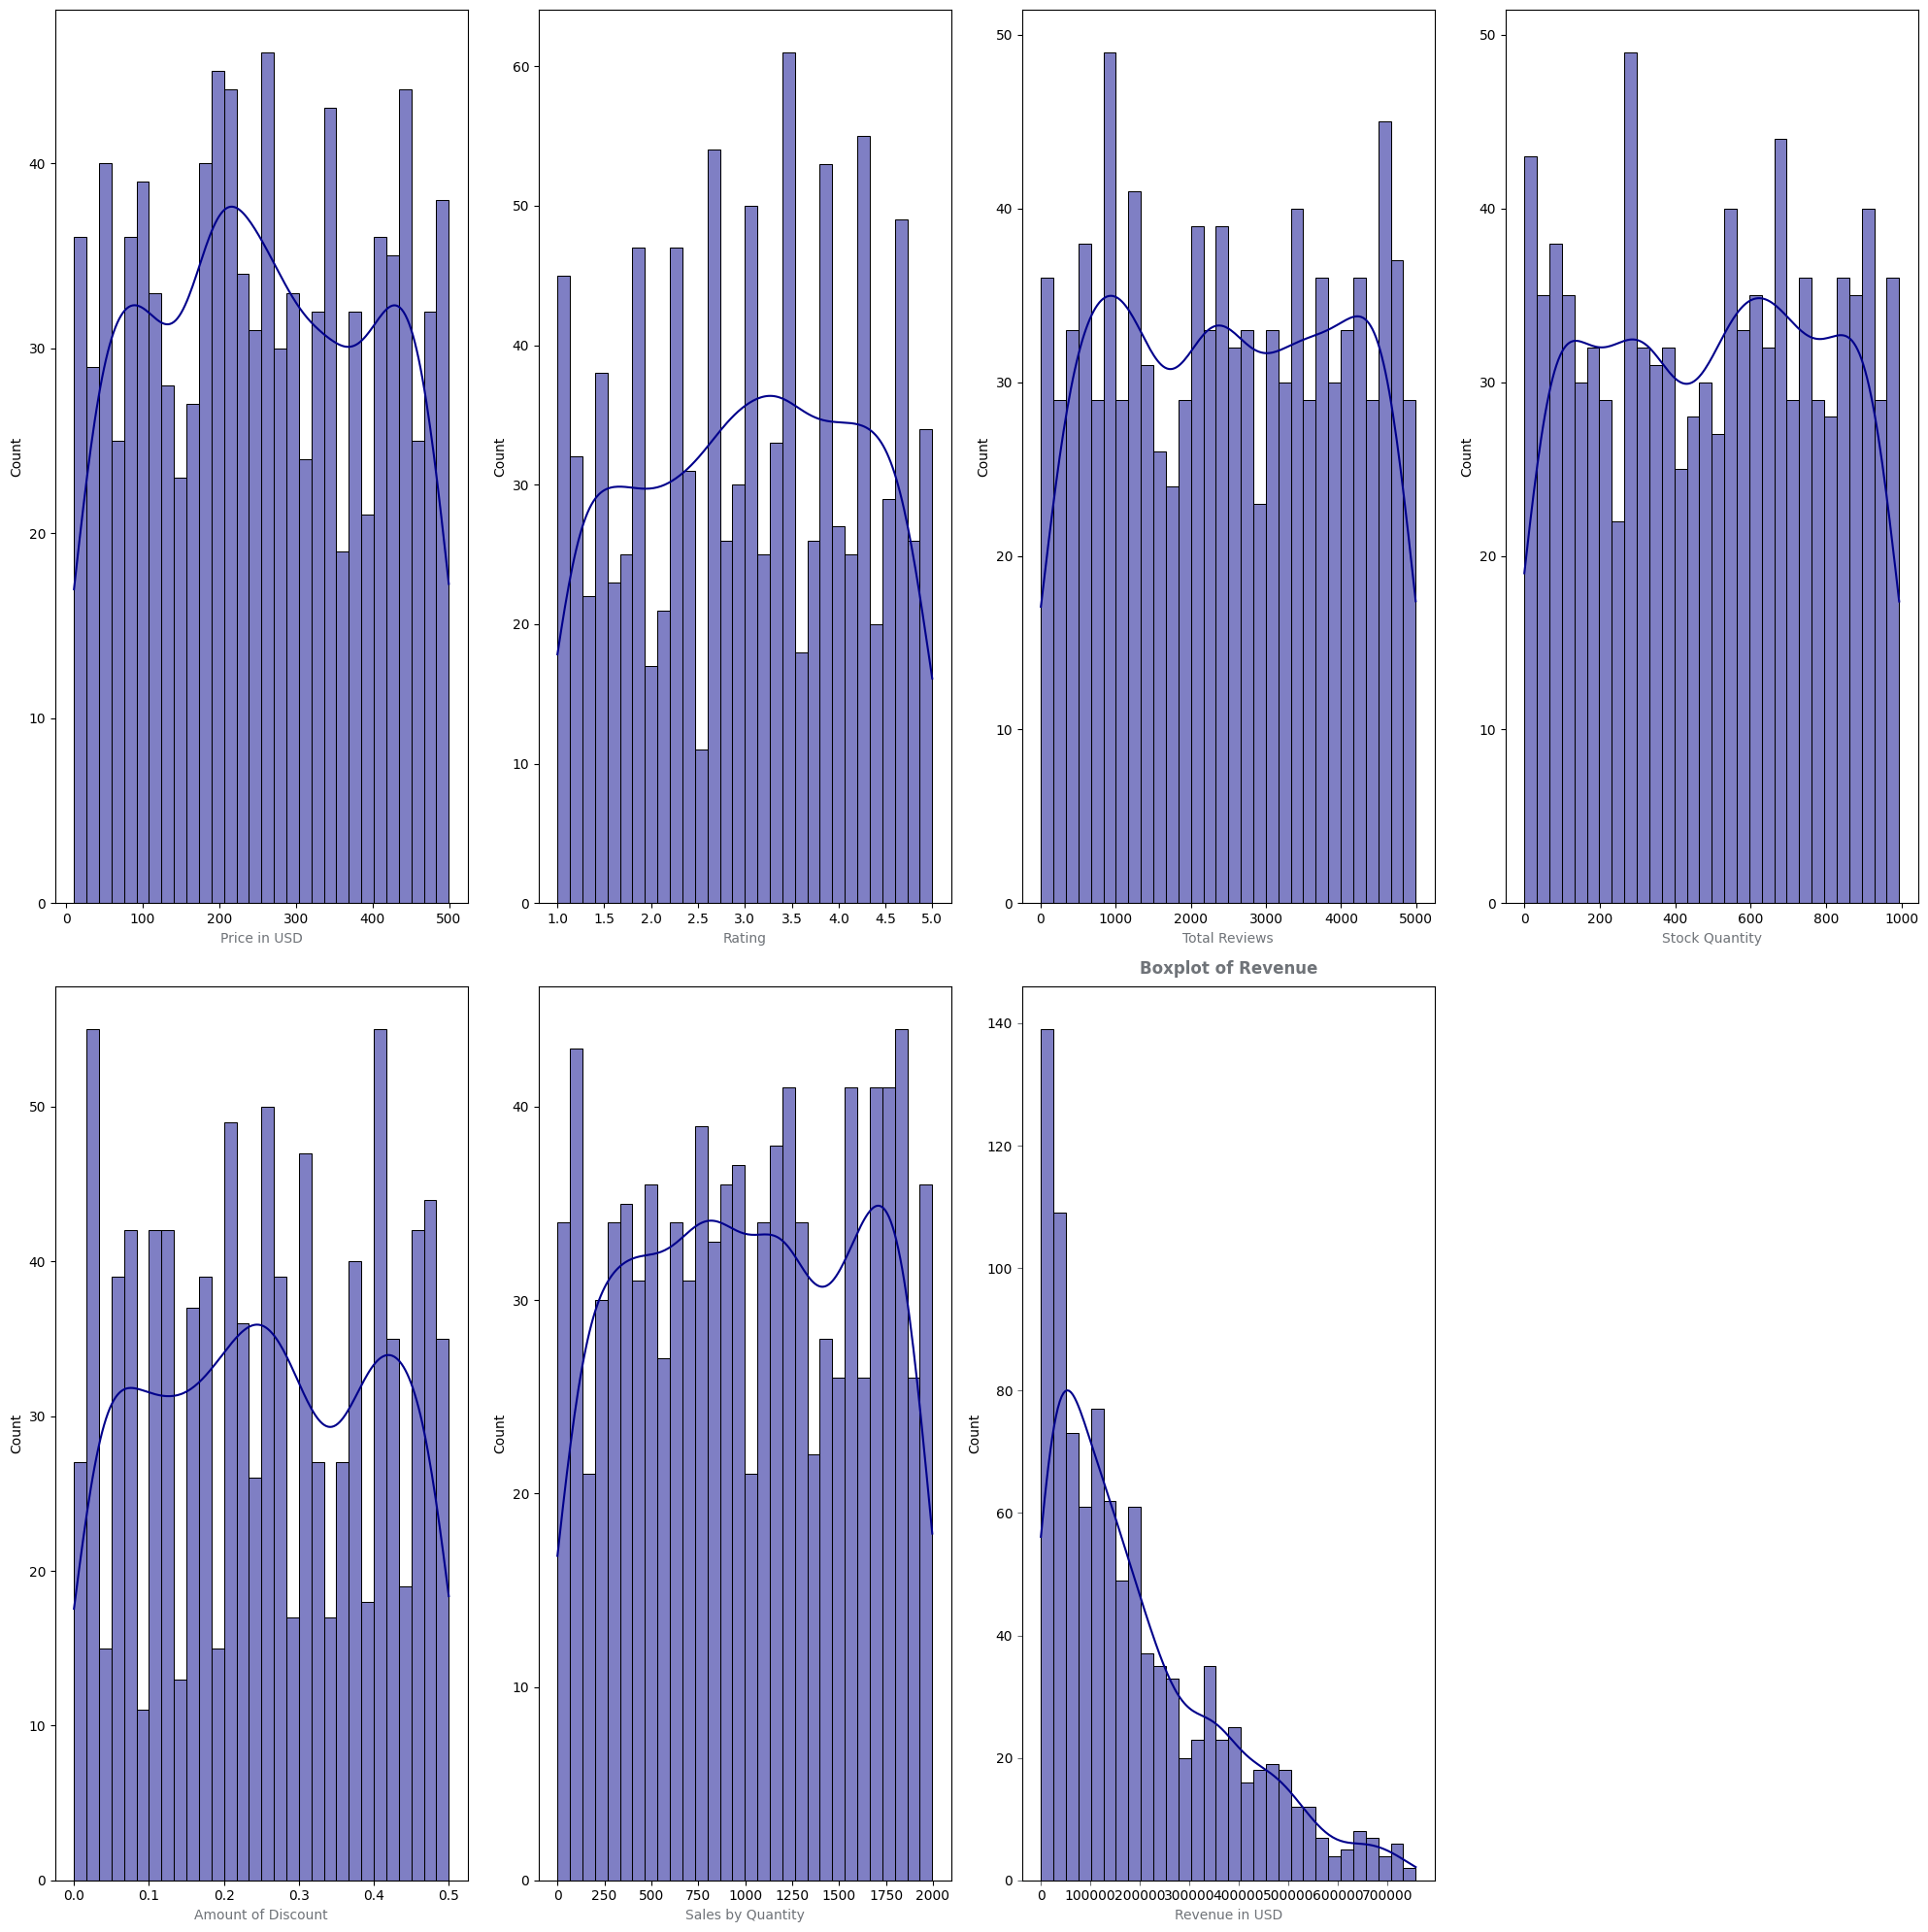

In [159]:
# Set up the plot with Gridspec
fig, ax = plt.subplots(2, 4, figsize=(20, 20), gridspec_kw={'height_ratios': [1, 1]})

# Flattent he ax array for easy iteration
ax = ax.flatten()

for i in range (len(num_var)):

    if num_var[i] == 'Price':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Price in USD', color='#6F7378')

    elif num_var[i] == 'Rating':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins=30, kde=True,ax=ax[i])
        ax[i].set_xlabel('Rating', color='#6F7378')
    
    elif num_var[i] == 'NumReviews':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Total Reviews', color='#6F7378')

    elif num_var[i] == 'StockQuantity':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins= 30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Stock Quantity', color='#6F7378')
    
    elif num_var[i] == 'Discount':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Amount of Discount', color='#6F7378')

    elif num_var[i] == 'Sales':
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins= 30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Sales by Quantity', color='#6F7378')

    else:
        sns.histplot(x=num_var[i], data=df, color='darkblue', bins=30, kde=True, ax=ax[i])
        ax[i].set_xlabel('Revenue in USD', color='#6F7378')

# Change the tick color
ax[i].tick_params(color='#6F7378')

ax[i].set_title(f'Boxplot of {num_var[i]}', weight='bold', color='#6F7378', pad=10)

# Remove the empty subplot
fig.delaxes(ax[-1])

plt.tight_layout()
plt.show()

Based on the observation of the plot, we can see that not all of the data is distributed normally. The details are:
- **Price**: The distribution appears to be roughly uniform, with mulyiple peaks and valleys. This indicates that the counts are relatively consistent across different price ranges, with no single price range dominating significantly.
- **Rating**: The rating distribution appears to be relatively uniform, with slight peaks and valleys with a tendency for rating counts to be slightly higher in the range of 3.0 to 4.0.
- **Total Reviews**: The distribution is fairly uniform, with several peaks and valleys and no strong skew towards any particular range of total reviews.
- **Stock Quantity**: The stock quantity distribution shows multiple peaks and valleys and the counts are somewhat evenly sprea across different uantities, though htere are noticeable peaks a certain quantities.
- **Amount of Discount**: The discount amount is distributed uniformly with multiple peaks and the counts are relatively consistent across different discount levels, indicating that discounts are spread across a range of values.
- **Sales by Quantity**: The sales quantity are relatively uniform with variety of peaks and valleys. Higher counts are observed to be in the mid-to-upper ranges, which indicates frequent sales at these quantities.
- **Revenue**: The revenue is heavyly positive-skewed. This indicates that lower revenue transactions are more common.

The conclusion are:
- Several variables display a **roughly uniform distribution** with multiple peaks and valleys, which suggest no single value dominates the dataset.
- The **Revenu** is the only variable that shows a skewness with a positive-skewness, which indicate a large number of lower revenue per transaction which dominates the dataset.
- Many variable shows **Peaks and Valleys** which suggest variability in the dataset and possible clustering at certain values.

Based on the conclusion, we should check using the measure of distribution and skewness.


In [160]:
df.skew(numeric_only=True)

Price            0.031605
Rating          -0.078781
NumReviews       0.000140
StockQuantity   -0.022212
Discount         0.000592
Sales           -0.017176
Revenue          1.056348
dtype: float64

Therefore, we can confirm our findings of the numeric variables, with `Revenue` having a high positive-skewness compared to the other numeric variables.

We can continue to our categorical variable. However, we should first examine the number of unique values of each categorical variable has to understand the diversity of the categorical data.

In [161]:
cat_var = df.select_dtypes(include=['category']).columns.to_list()

for i in cat_var:
    display(df[i].value_counts())
    print(f'Unique values: {len(df[i].unique())} \n')

ProductID
1       1
672     1
659     1
660     1
661     1
       ..
339     1
340     1
341     1
342     1
1000    1
Name: count, Length: 1000, dtype: int64

Unique values: 1000 



ProductName
Biography          22
Mountain Bike      19
Throw Blanket      18
Denim Jacket       17
Eau de Toilette    15
                   ..
Rain Jacket         5
Winter Coat         5
Cuticle Oil         5
Pillar Candle       4
Fantasy Book        4
Name: count, Length: 100, dtype: int64

Unique values: 100 



Category
Art and crafting materials    40
Makeup                        40
Vitamins and supplements      40
Underwear                     40
Toys & Games                  40
Socks                         40
Skin care                     40
Posters and artwork           40
Perfume and cologne           40
Nail care                     40
Motor vehicle parts           40
Mobile phone accessories      40
Home & Kitchen                40
Bath and body                 40
Electronics                   40
Drinkware                     40
Cookware                      40
Coats and jackets             40
Clothing                      40
Candles                       40
Books                         40
Blankets                      40
Bicycles                      40
Bedsheets                     40
Wine                          40
Name: count, dtype: int64

Unique values: 25 



City
New York         17
Spokane          17
Palm Bay         17
San Francisco    16
San Jose         15
                 ..
Long Beach        5
Worcester         5
Springfield       4
Nashville         4
Brooklyn          3
Name: count, Length: 101, dtype: int64

Unique values: 101 



Day
Thursday     155
Saturday     148
Monday       144
Sunday       144
Wednesday    142
Tuesday      137
Friday       130
Name: count, dtype: int64

Unique values: 7 



Month
July         100
November      96
August        89
September     86
December      84
October       81
March         80
May           79
April         78
February      77
January       75
June          75
Name: count, dtype: int64

Unique values: 12 



With different amounts of unique values of the categorical variables, we'll use different visualization techniques.
- We can remove `ProductID` since each value of it are unique. However, this can be used as an identifier.
- For `Category`, `ProductName`, and `City`, bar chart which focus on the top N.

Now, we can continue to see the distributions of the categorical variable using a countplot.

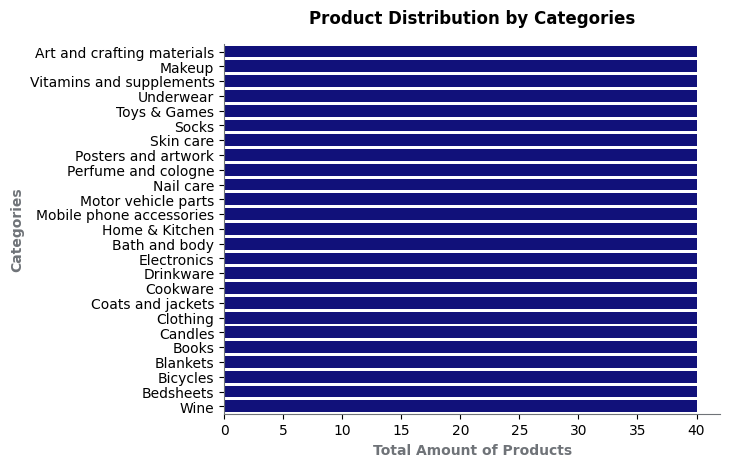

In [162]:
# Set up the figure and axes
fig, ax = plt.subplots()

# Create the countplot
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index,
              color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Set the labels
ax.set_xlabel('Total Amount of Products', weight='bold', color='#6F7378')
ax.set_ylabel('Categories', weight='bold', color='#6F7378')

# Style the spine
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_title('Product Distribution by Categories', pad=15, weight='bold')

plt.show()

When distributed by the category, sold products are uniformly distributed at 40 products at each categories.

Then, we should see the distribution by top 10 product name.

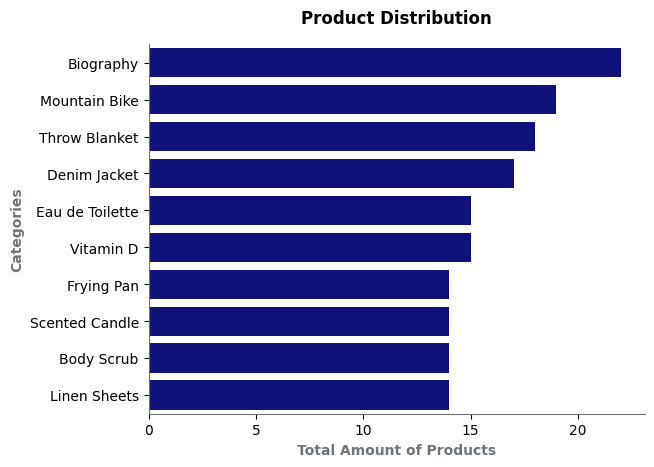

In [163]:
# Set up the figure and axes
fig, ax = plt.subplots()

# Create the countplot
sns.countplot(y=df['ProductName'], order=df['ProductName'].value_counts().iloc[:10].index,
              color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Set the labels
ax.set_xlabel('Total Amount of Products', weight='bold', color='#6F7378')
ax.set_ylabel('Categories', weight='bold', color='#6F7378')

# Style the spine
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_title('Product Distribution', pad=15, weight='bold')

plt.show()

Based on the plot, we can conclude that our data has a large number of unique variables with over 100 different products sold. Moreover, it is identified that **Biography** has the higest frequency, accounting over 22 transactions. 

Now, let's see the distribution by the city.

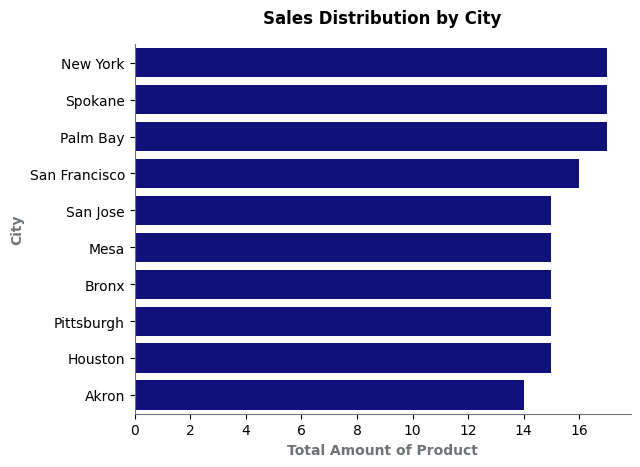

In [164]:
# Set up the figure and axes
fig, ax = plt.subplots()

# Create the countplot
sns.countplot(y=df['City'], order=df['City'].value_counts().iloc[:10].index,
              color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Set the labels
ax.set_xlabel('Total Amount of Product', weight='bold', color='#6F7378')
ax.set_ylabel('City', weight='bold', color='#6F7378')

# Style the spine
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_title('Sales Distribution by City', pad=15, weight='bold')

plt.show()

Based on the countplot of sales distribution by city, we can infer the following:
- **New York**, **Spokane**, and **Palm Bay** has the highest total amount of products which indicates that these three city are important markets for the e-commerce.
- There is a relatively consistent sales distribution across cities such as, San Jose, Mesa, Bronx, Pittsburgh, and Houston, suggesting a balanced distribution in these locations.

## **3.3 EDA: Bivariate and Multivariate Analysis**
We'll begin our exploration by examining the relationships between numerical variables, which are:
1. `Price`
2. `Rating`
3. `NumReviews`
4. `StockQuantity`
5. `Discount`
6. `Sales`
Therefore, we should investigate the correlation of these variables to assess the strength and direction of linear relationships between these variables.

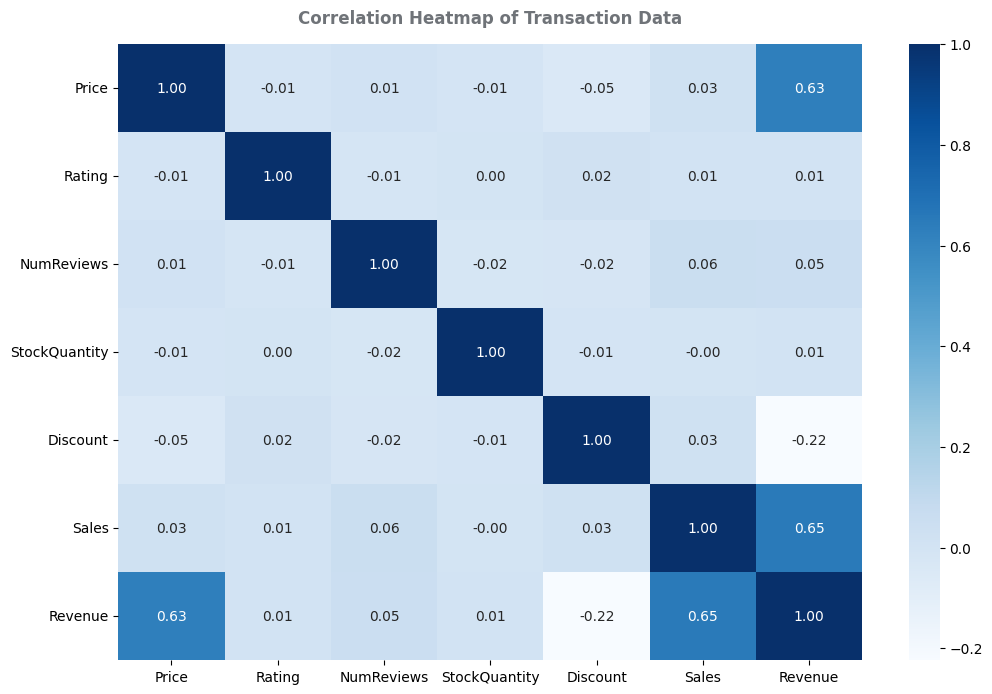

In [165]:
# Set the figure and axes
fig, ax = plt.subplots(figsize=(12,8))

# Create the correlation heatmap
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues',
            fmt='.2f', ax=ax)

# Add title
ax.set_title('Correlation Heatmap of Transaction Data', pad=15, weight='bold', color='#6F7378')

plt.show()

Based on the correlation heatmap of transaction data, we can infer the following:
- **Price** and **Revenue** has a strong positive correlation with a value of 0.63, indicating that higher prices are associate with higher revenue.
- **Sales** and **Revenue** also show a strong positive correlation with a value of 0.65 which suggest that an increase in sales quantity contributes significantly to revenue growth.
- There is a moderate negative correlation between **Discount** and **Revenue** which implies that a higher discount rate may lead to a lower revenue by reducing the profit margins.
- For the other variables, there are no strong linear relationships among them.

We should continue by checking the relationship between numerical data using a pair plot.

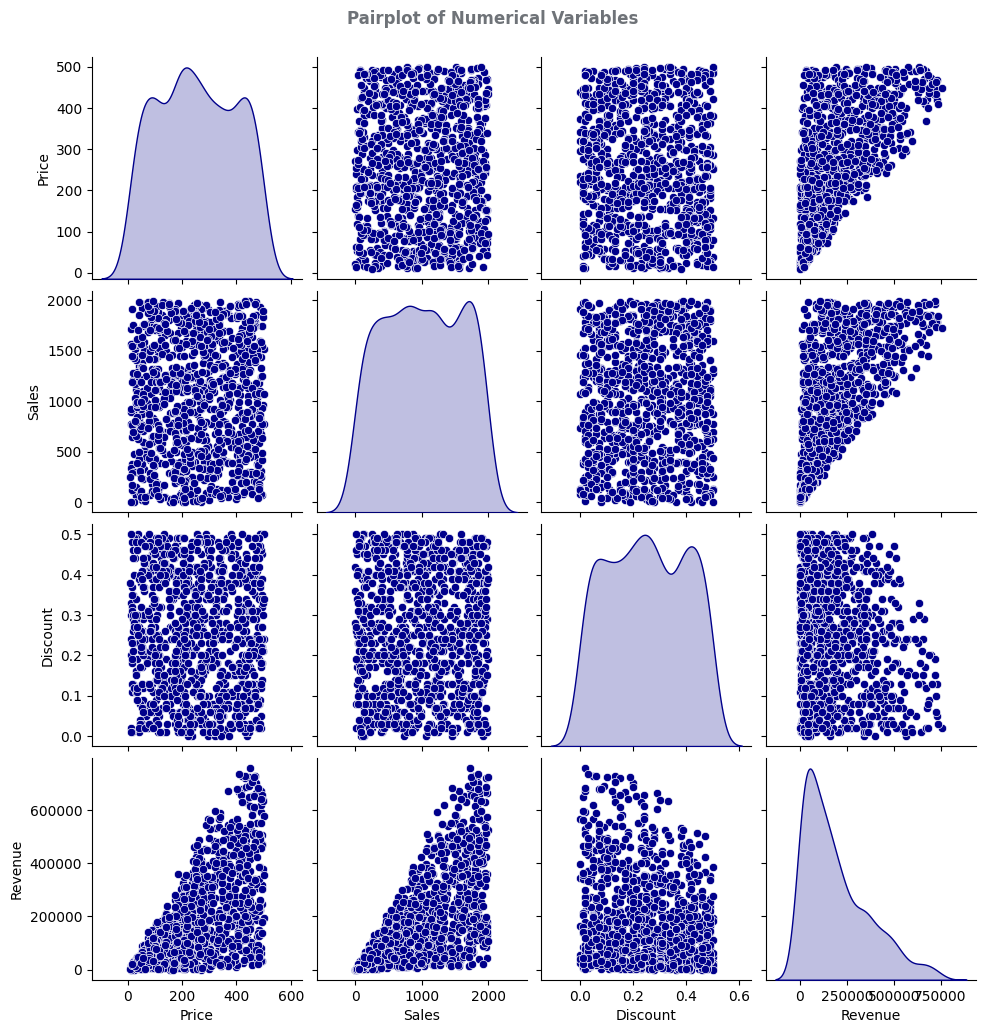

In [166]:
# Create the pair plot
sns.pairplot(df[['Price', 'Sales', 'Discount', 'Revenue']], diag_kind='kde',
             plot_kws=dict(color='darkblue'), diag_kws=dict(color='darkblue'))

# Add the title
plt.suptitle('Pairplot of Numerical Variables', weight='bold', color='#6F7378', y=1.03)

plt.show()

Based on the pair plot, we can conclude the following:
- We can see from the plot that both **Price** and **Sales** has a significant impact on **Revenue** with a clear positive relationship.
- However, the relationship between **Price** and **Sales** is not strongly linear, suggesting that the quantity of sales does not directly depend on the price alone. Other factors might be affecting sales quantities, such as product category, market demand, or promotions.
- Consistent with the correlation heatmap, the relationship between **Discount** and **Revenue** shows a negative linear characteristics. As higher discount is added into the transaction, there would be less revenue.

#### **Transaction Sales Performance**
Next, we are going to analyze the temporal aspects of transactions by analyzing the performance of `Revenue` over time. Since `Revenue` was calculated from `Price`, `Quantity`, and `Discount`, it comprehensively represents sales performance and transaction patterns.

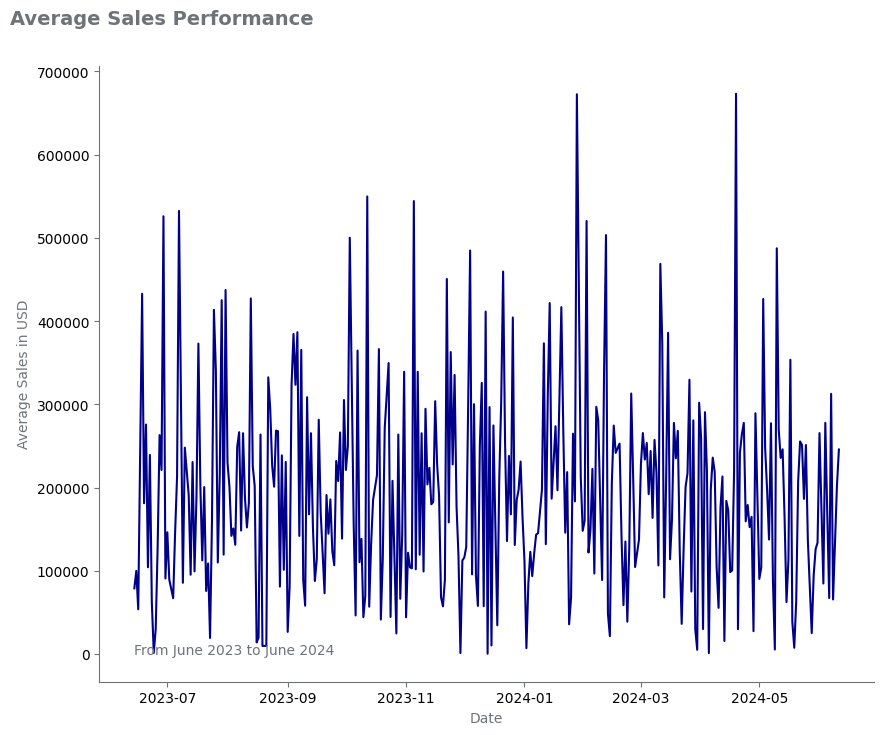

In [167]:
# Set the figure and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot the sales trend across the date
sns.lineplot(x='DateAdded', y='Revenue', data=df, ci=None, color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Set the label
ax.set_xlabel('Date', color='#6F7378')
ax.set_ylabel('Average Sales in USD', color='#6F7478')

# Change the spine color
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Set the title
ax.set_title('Average Sales Performance', weight='bold', pad=30, size=14, x=-0.115,
             color='#6F7378', ha='left')
ax.text(s='From June 2023 to June 2024', x=pd.Timestamp('2023-06-14'), y=360, color='#6F7378' )

# Change tick color
ax.tick_params(color='#6F7378')

plt.show()

Based on the plot, we can see that the sales performance is highly volatile, with significant fluctuations in average sales on a day-to-day basis with several peaks and troughs throughout the year, suggesting possible seasonal effects. There are high peaks visible in the grap, notably around late 2023 and early 2024 and noticeable periods where sales dip significantly. Moreover, the graph exhibits short-term volatility, with sales figure rapidly rising and falling which could be due to various factors like market demand fluctuations, stock availability, pricing strategies, or external economic conditions.

Next, step is to see the monthly and daily sales trends for a more detailed analysis.


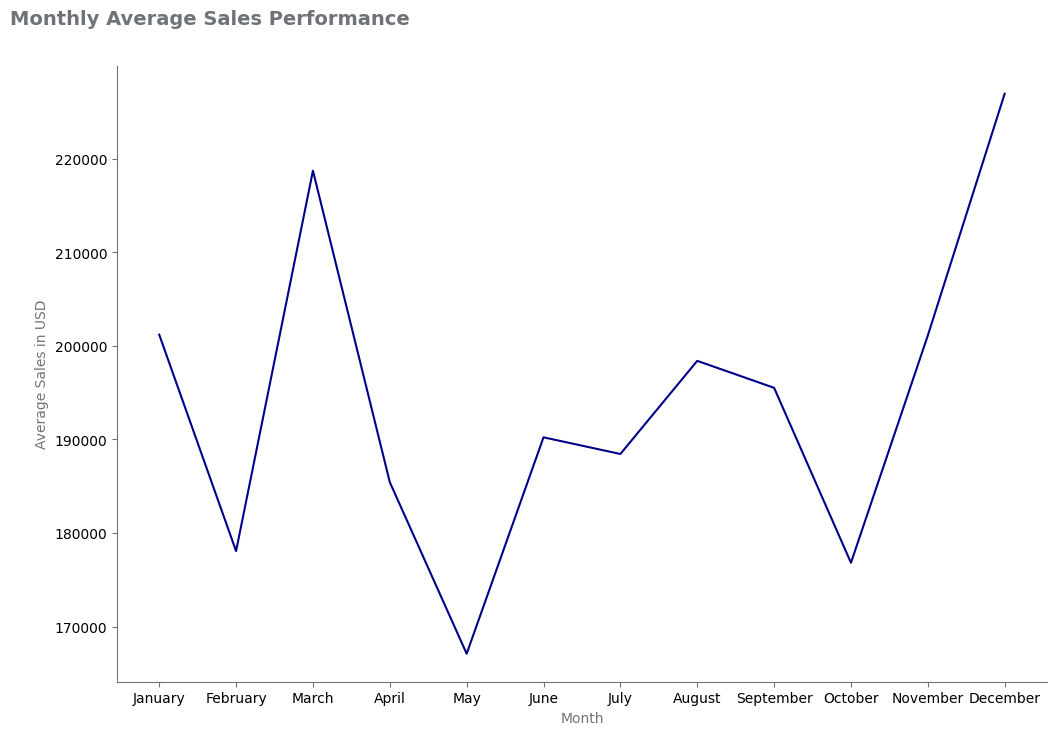

In [168]:
# Set the figure and axes
fig, ax = plt.subplots(figsize=(12,8))

# Plot the sales trend across the date
sns.lineplot(x='Month', y='Revenue', data=df, ci=None, color='darkblue', ax=ax)

# Despine the right side
sns.despine(right=True)

# Set the label
ax.set_xlabel('Month', color='#6F7378')
ax.set_ylabel('Average Sales in USD', color='#6F7478')

# Change the spine color
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Set the title
ax.set_title('Monthly Average Sales Performance', weight='bold', pad=30, size=14, x=-0.115,
             color='#6F7378', ha='left')

# Change tick color
ax.tick_params(color='#6F7378')

plt.show()

When analyzed for its monthly sales. We can see that there is a seasonal pattern and changes in the monthly sales. There are several patterns from this plot which can be pointed out:
1. **Sales Fluctuation**
    - *High Points*: Sales peak in March, August, and December suggesting an increase in sales.
    - *Low Points*: Sales dip in Feburary, May, and October suggesting a decrease in sales.
2. **Seasonal Influence**
    - *March and December Peaks* might be influenced by end-of-quarter sales in March and holiday season sales in December.
    - *August Peak* might be related to summer promotions or increased consumer spending during the holiday season.

To better understand the sales trend, we can examine the average price and quantity across all months.

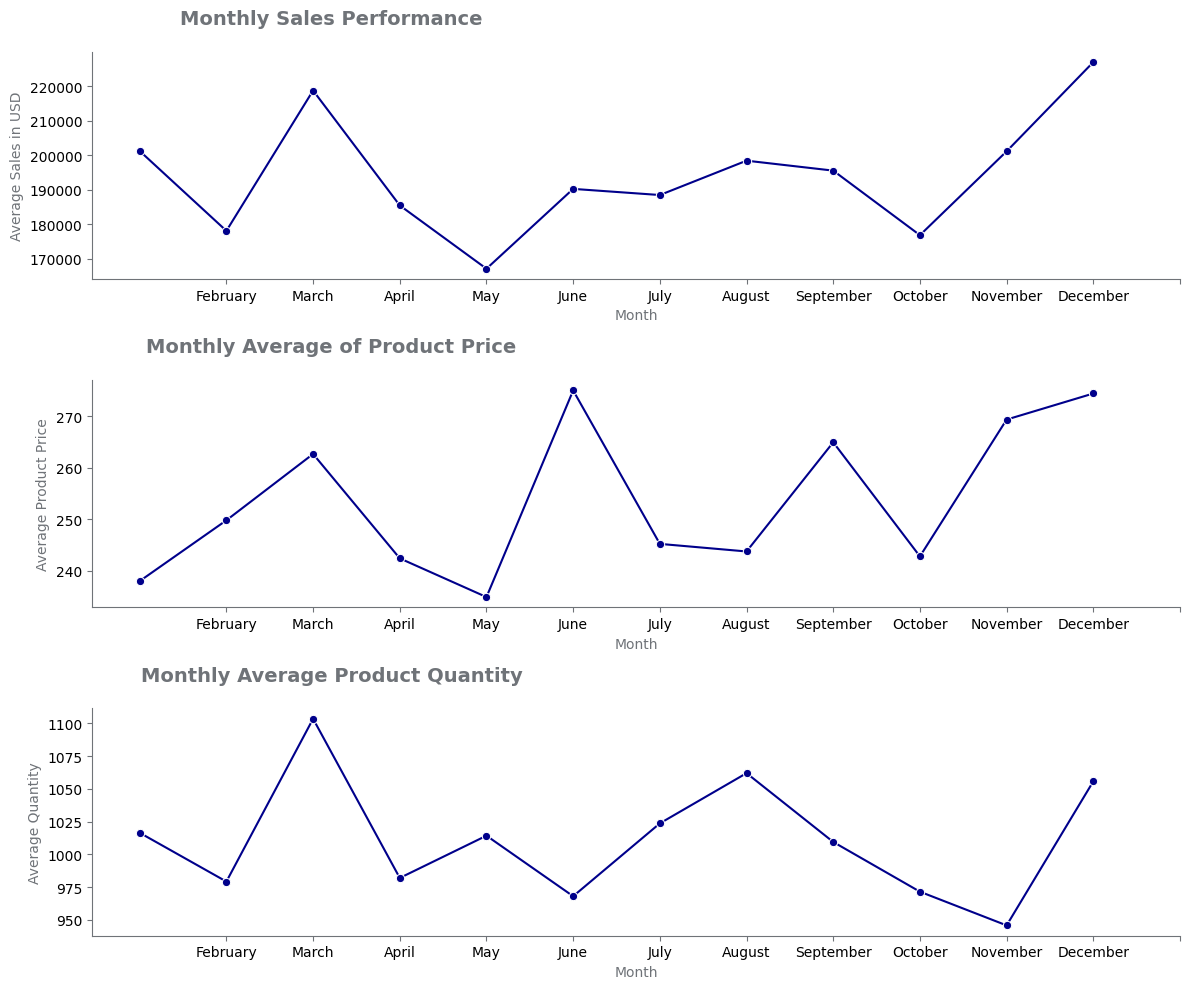

In [169]:
# Get the list of Price and Sales(Quantity)
price_qty = ['Revenue', 'Price', 'Sales']

# Set up the figure and axes
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Loop to create lineplot for each variable
for i in range(len(price_qty)):
    if price_qty[i] == 'Revenue':
        sns.lineplot(x='Month', y=price_qty[i], data=df,
                     ci=None, color='darkblue', marker='o', ax=ax[i])
        ax[i].set_title('Monthly Sales Performance', pad=20, x=0.22,
                        size=14, weight='bold', color='#6F7378')
        ax[i].set_ylabel('Average Sales in USD', color='#6F7378')
    elif price_qty[i] == 'Price':
        sns.lineplot(x='Month', y=price_qty[i], data=df,
                     ci=None, color='darkblue', marker='o', ax=ax[i])
        ax[i].set_title('Monthly Average of Product Price', pad=20, x=0.22,
                        size=14, weight='bold', color='#6F7378')
        ax[i].set_ylabel('Average Product Price', color='#6F7378')
    elif price_qty[i] == 'Sales':
        sns.lineplot(x='Month', y=price_qty[i], data=df,
                     ci=None, color='darkblue', marker='o', ax=ax[i])
        ax[i].set_title('Monthly Average Product Quantity', pad=20, x=0.22,
                        size=14, weight='bold', color='#6F7378')
        ax[i].set_ylabel('Average Quantity', color='#6F7378')
        
    ax[i].set_xlabel('Month', color='#6F7378')
    ax[i].set_xticks(range(1, 13))
    ax[i].tick_params(color='#6F7378')

    sns.despine(right=True)

    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')

plt.tight_layout()
plt.show()


Higher average prices in June might be associated with premium product or price hikes. The drop in April could be linked to discounts or sales promotions. The high quantities in March and December reinforce the idea of strong seasonal demand. The decrease in mid-year could be due to lower consumer demand or fewer marketing efforts.

The revenue trends correlate with both the average price and quantity. For instance, March and December have high revenue, high average quantity, and variable prices. This suggests that both higher prices and higher quantities sold contribute to revenue peaks.

As the monthly sales trend has been analyzed, we now can continue to the daily sales performance categorized by `Day`.

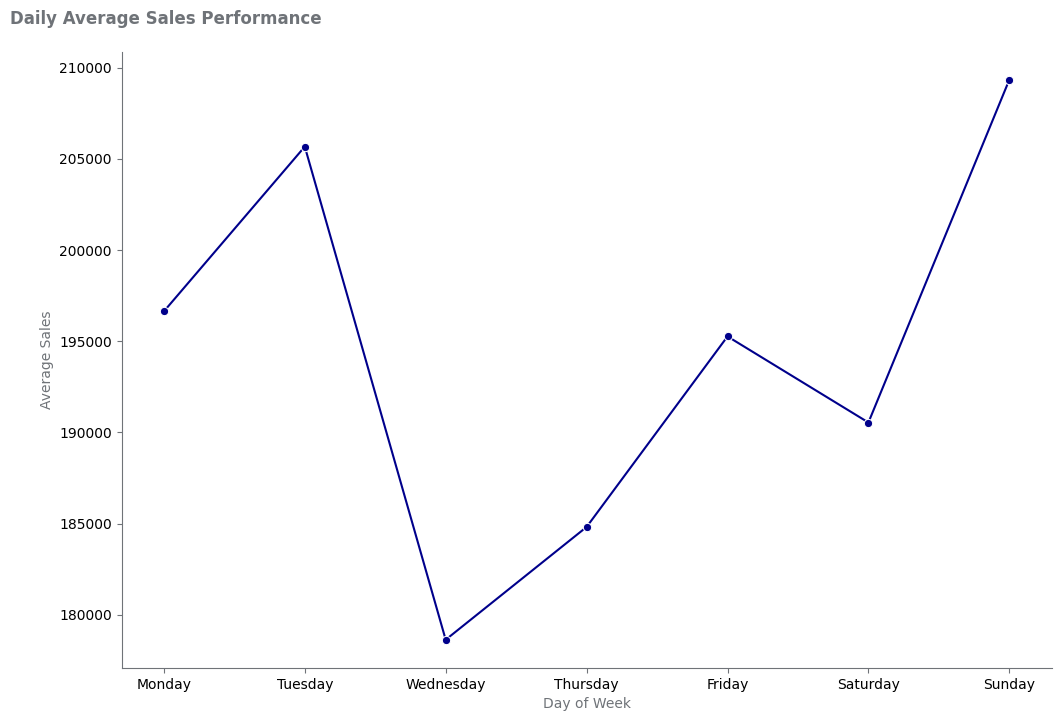

In [170]:
# Set the figure and axes
fig, ax = plt.subplots(figsize=(12,8))

# Plot the daily sales performance
sns.lineplot(x='Day', y='Revenue', data=df, ci=None, color='darkblue',
             marker='o', ax=ax)

# Despine the right side
sns.despine(right=True)

ax.set_xlabel('Day of Week', color='#6F7378')
ax.set_ylabel('Average Sales', color='#6F7378')

for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_title('Daily Average Sales Performance', pad=20, x=-0.12,
             weight='bold', color='#6F7378', ha='left')
ax.tick_params(color='#6F7378')

plt.show()

When plotting the daily average sales, it can be seen that there is a notable uptrend in the end of the week, with sales peaking on Sunday. In contrast, customer tends to buy less during the midweek from Tuesday to Wednesday. This might be due to the fact that majority of the customers having less leisure time to go shopping.

### **Into the Cities**

To gain an overview of the sales patterns across different cities, we should examine the asles distribution by cities. First, we will aggregate the total `Revenue` by each city in this dataset and use a cloropleht map to see the overall distribution of sales accross the cities in the US.

In [ ]:
geolocator = Nominatim(user_agent="city_geocoder")

def get_lat_long(city):
    location = geolocator.geocode(city)
    return(location.latitude, location.longitude)

df['Coordinates'] = df['City'].apply(get_lat_long)
df[['Latitude', 'Longitude']] = pd.DataFrame(df['Coordinates'].tolist(), index=df.index)

# Aggregate the data by city
df = df.groupby('City').sum().reset_index()

